<a href="https://colab.research.google.com/github/tomastm07/U-Net-Brain-MRI-segmentation/blob/main/Brain_MRI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
In this notebook, I'll build a variant of the U-Net model using Keras. Known for its U-shaped architecture, U-Net is widely used in image segmentation tasks, including medical imaging and autonomous driving applications. I'll demonstrate its capabilities by applying it to a Brain MRI tumor detection task.

In [1]:
!pip install kaggle


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

zip_path = '/content/lgg-mri-segmentation.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [23]:
import pandas as pd
import os
import tensorflow as tf
data = []

for dirpath, dirnames, filenames in os.walk('/content/kaggle_3m'):
    for filename in filenames:
        if filename.endswith('.tif'):
            file_path = os.path.join(dirpath, filename)
            data.append(file_path)

data[:5]

['/content/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_15.tif',
 '/content/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_21.tif',
 '/content/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14.tif',
 '/content/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27_mask.tif',
 '/content/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_6.tif']

In [24]:
import cv2
from tqdm import tqdm

def tiff_to_jpeg_with_opencv(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    jpeg_path = img_path.replace('.tif', '.jpeg')
    cv2.imwrite(jpeg_path, img_rgb)
    return jpeg_path

def parse_image(img_path):

    if not os.path.exists(img_path):
        raise ValueError(f"JPEG file does not exist: {img_path}")

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img

def parse_mask(mask_path):

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128])
    mask = mask //
    return mask

def pair_images_masks(data):
    img_paths = sorted([path for path in data if 'mask' not in path])
    mask_paths = sorted([path for path in data if 'mask' in path])

    paired_data = []
    for img_path in img_paths:
        # Construct the mask path based on the image path
        mask_path = img_path.replace('.tif', '_mask.tif')
        if mask_path in mask_paths:
            paired_data.append((img_path, mask_path))

    return paired_data

data = pair_images_masks(data)
print(data[:10])



Converting to JPEG: 0it [00:15, ?it/s]

[('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif', '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif'), ('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif', '/content

In [26]:


# Convert all TIFF to JPEG
[ (tiff_to_jpeg_with_opencv(img_path), tiff_to_jpeg_with_opencv(mask_path) ) for img_path, mask_path in tqdm(data, desc="Converting to JPEG")]


data = [(path.replace('.tif', '.jpeg'), mask_path.replace('.tif', '.jpeg')) for path, mask_path in data]




Converting to JPEG: 100%|██████████| 3929/3929 [00:11<00:00, 330.52it/s]


In [27]:
#Decode images
data = [(parse_image(img_path),parse_mask(mask_path)) for  img_path, mask_path in data]

In [39]:
#Create dataset, train and val
images = [x[0] for x in data]
masks = [x[1] for x in data]
dataset = tf.data.Dataset.from_tensor_slices((images, masks))

num_samples = len(data)
train_size = int(0.7 * num_samples)
val_size = num_samples - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.batch(16).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(buffer_size=AUTOTUNE)


In [40]:
for images, masks in train_dataset.take(3):
    print(images.shape)
    print(masks.shape)
print("---------------")
print(model.input_shape)
print(model.output_shape)

(16, 128, 128, 3)
(16, 128, 128, 1)
(16, 128, 128, 3)
(16, 128, 128, 1)
(16, 128, 128, 3)
(16, 128, 128, 1)
---------------
(None, 128, 128, 3)
(None, 128, 128, 1)


In [46]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 128, 128, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 128, 128, 64)         256       ['conv2d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_96 (Conv2D)          (None, 128, 128, 64)         36928     ['batch_normalization_90[0

In [44]:
#Create and compile model

def build_unet(input_shape=(128, 128, 3)):
    def conv_block(input, num_filters):
        x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

    def encoder_block(input, num_filters):
        x = conv_block(input, num_filters)
        p = tf.keras.layers.MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input, skip_features, num_filters):
        x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input)
        x = tf.keras.layers.concatenate([x, skip_features])
        x = conv_block(x, num_filters)
        return x

    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)

    model = tf.keras.Model(inputs, outputs, name='U-Net')
    return model

model = build_unet(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
# Train the model
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

EPOCHS = 50
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[early_stop_callback])


Epoch 1/50
172/172 [==============================] - 69s 329ms/step - loss: 0.3525 - accuracy: 0.9472 - val_loss: 0.1771 - val_accuracy: 0.9912
Epoch 2/50
172/172 [==============================] - 43s 253ms/step - loss: 0.0577 - accuracy: 0.9939 - val_loss: 0.0508 - val_accuracy: 0.9912
Epoch 3/50
172/172 [==============================] - 44s 255ms/step - loss: 0.0307 - accuracy: 0.9935 - val_loss: 0.0440 - val_accuracy: 0.9912
Epoch 4/50
172/172 [==============================] - 43s 253ms/step - loss: 0.0245 - accuracy: 0.9938 - val_loss: 0.0487 - val_accuracy: 0.9914
Epoch 5/50
172/172 [==============================] - 44s 254ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0387 - val_accuracy: 0.9919
Epoch 6/50
172/172 [==============================] - 43s 253ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0364 - val_accuracy: 0.9928
Epoch 7/50
172/172 [==============================] - 43s 253ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0358 - val_ac

In [47]:
#Test the model

1/1 [==============================] - 0s 22ms/step


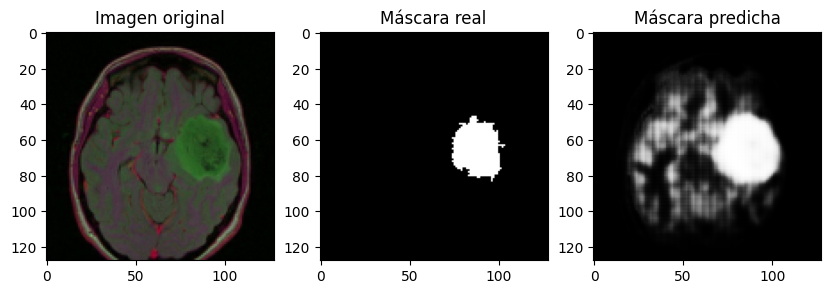

1/1 [==============================] - 0s 22ms/step


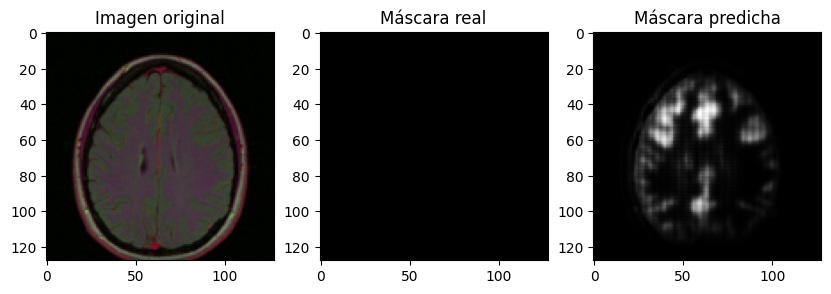

1/1 [==============================] - 0s 23ms/step


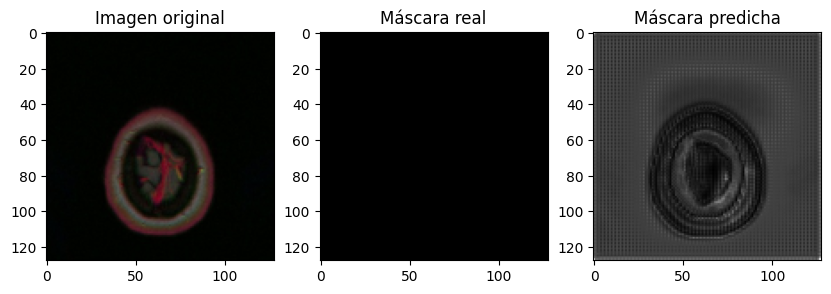

1/1 [==============================] - 0s 25ms/step


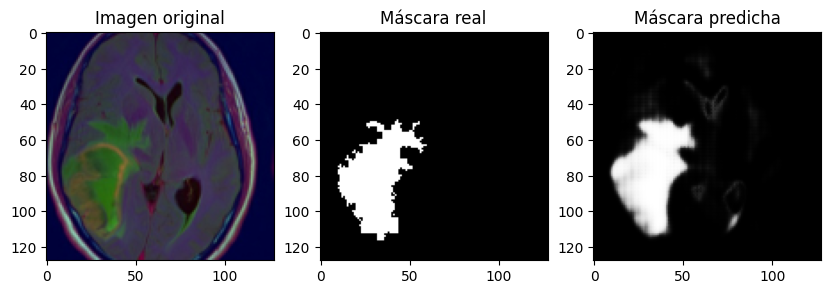

1/1 [==============================] - 0s 26ms/step


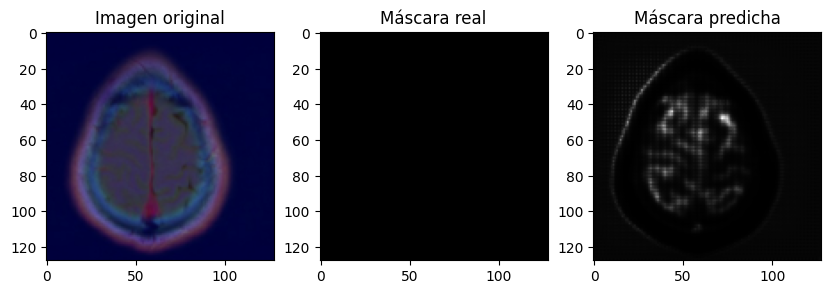

1/1 [==============================] - 0s 23ms/step


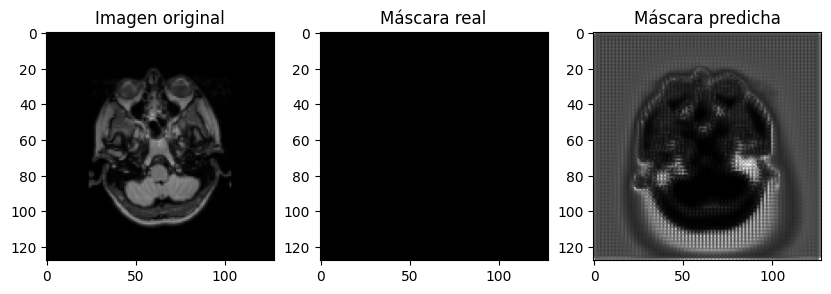

1/1 [==============================] - 0s 23ms/step


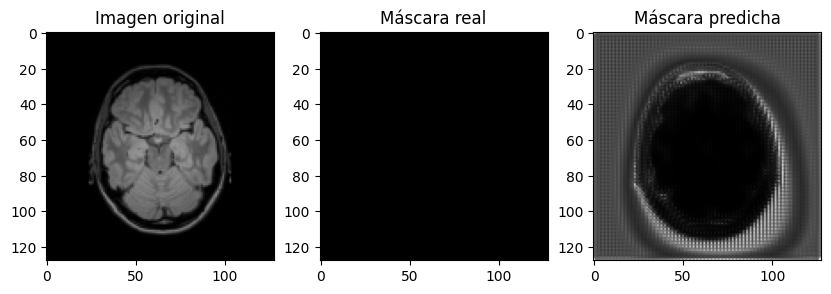

1/1 [==============================] - 0s 23ms/step


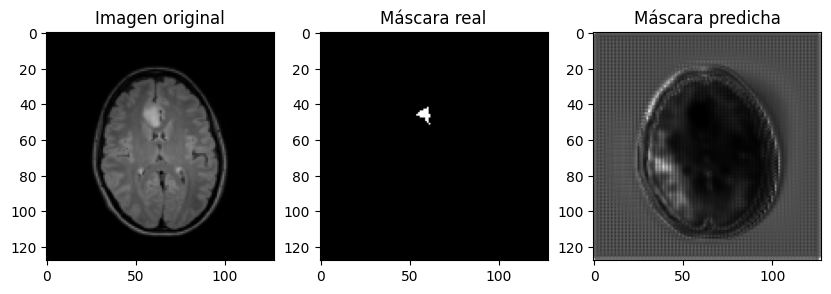

1/1 [==============================] - 0s 25ms/step


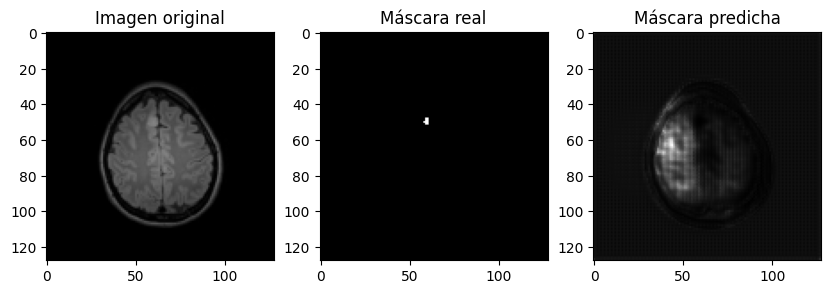

1/1 [==============================] - 0s 23ms/step


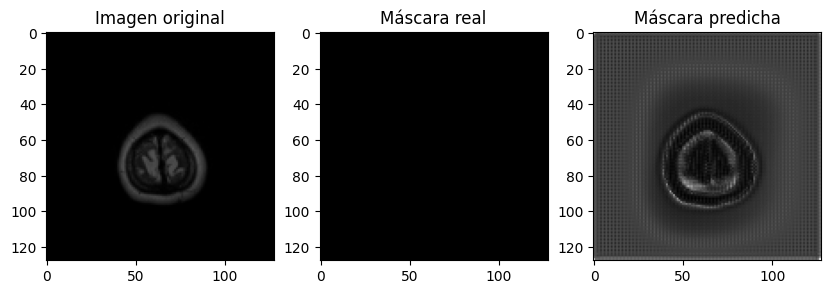

In [50]:
import matplotlib.pyplot as plt

# Elige 4 imágenes aleatorias del conjunto de validación
for img, mask in val_dataset.take(10):
    # Usa el modelo para predecir la máscara
    predicted_mask = model.predict(img)

    # Visualiza las imágenes, las máscaras reales y las máscaras predichas
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img[0].numpy())
    plt.title("Imagen original")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy().squeeze(), cmap='gray')
    plt.title("Máscara real")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0].squeeze(), cmap='gray')
    plt.title("Máscara predicha")

    plt.show()
